In [106]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10


In [107]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


In [108]:

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


last 3 indicates the images in RGB color format

In [109]:
import numpy as np
#Unique classes in the image 
num_unique_classes = len(np.unique(y_train))
print("Number of unique classes:", num_unique_classes)

Number of unique classes: 10


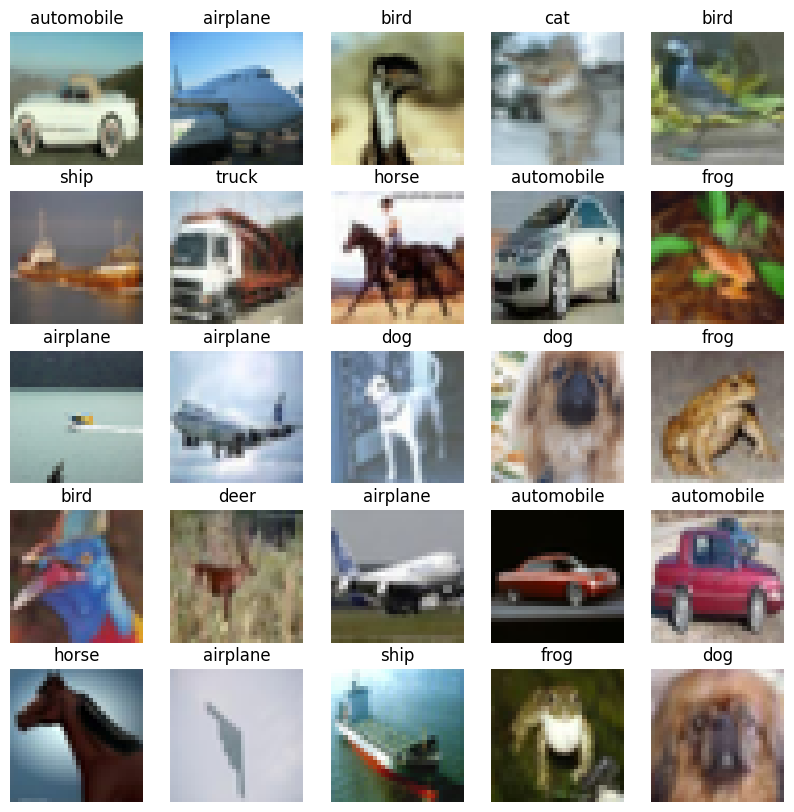

In [110]:
import matplotlib.pyplot as plt
#define predefined class labels for CIFAR-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#visualize the data 
plt.figure(figsize= (10, 10))
for i in range(25):
    ax = plt.subplot(5, 5,  i+1) #takes num of rows, num of columns and index of the subplot
    rand_index = tf.random.uniform([], 0, len(X_train), dtype= tf.int32)
    plt.imshow(X_train[rand_index])
    plt.title(class_labels[int(y_train[rand_index])])
    plt.axis("off")
plt.show()



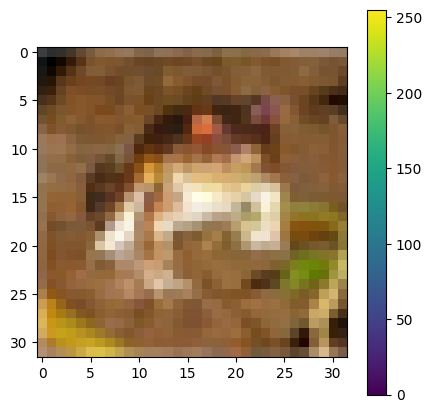

In [111]:
plt.figure(figsize= (5,5))
plt.imshow(X_train[0])
plt.colorbar()
plt.gca().grid(False)

### Data normalization 

In [112]:
# X_train, X_test = X_train/255. , y_train/255. 

In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define batch size
batch_size = 32
# create ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,             # normalizing the pixel values to [0, 1]
    rotation_range=20,          # randomly rotating images by up to 20 degree
    width_shift_range=0.1,      # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,     # randomly shift images vertically by up to 10%
    horizontal_flip=True       # randomly flip images horizontally
)
# fit ImageDataGenerator on training data
datagen.fit(X_train)
# create data generator for training dataset
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
# create data generator for test dataset 
test_generator = ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=batch_size)


In [114]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Nadam, Adadelta, RMSprop
from tensorflow.keras.regularizers import l2

In [115]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Flatten(input_shape = (32, 32, 3)))

    #hyperparameters
    n_hidden = hp.Int("n_hidden", min_value = 0, max_value = 8, default = 2)
    n_neurons_1 = hp.Int("n_neurons_1", min_value = 16, max_value = 256)
    n_neurons_2 = hp.Int("n_neurons_2", min_value = 16, max_value = 256)
    learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 1e-2, sampling = 'log')  #sampling="log", learning rates of all scales will be sampled equally.
    hp_activation = hp.Choice('activation', values = ['relu', 'tanh'])
    optimizer = hp.Choice("optimizer", values = ["sgd", "adam",  "adadelta"])
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value = 0.5, default = 0.2) # Specify dropout rate
    l2_lambda = hp.Float("l2_lambda", min_value=1e-6, max_value=1e-2, sampling='log')
    momentum = hp.Float("momentum", min_value = 0.0, max_value = 0.99, default = 0.9)
    initializer = hp.Choice("initializer", values = ["he_normal", "glorot_normal"])
    # Add hidden layers based on hyperparameters
    for i in range(n_hidden):
        model.add(layers.Dense(units = n_neurons_1 if i == 0 else n_neurons_2, 
                               activation = hp_activation, 
                               kernel_regularizer = l2(l2_lambda),
                               kernel_initializer = initializer
                               ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate)) # Add dropout layer after each hidden layer
    
    #output layer
    model.add(layers.Dense(10, activation = 'softmax'))
    #choose optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate = learning_rate)#adam doesnt support momentum
    elif optimizer == "sgd":
        optimizer = SGD(learning_rate=learning_rate, momentum = momentum) 
    else:
        optimizer = Adadelta(learning_rate=learning_rate) #Adadelta doesnt support momentum 
    # Compile the model
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

    return model

In [116]:
import keras_tuner as kt


# Instantiating the tuner
tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 3,  # Leads to faster tuning time as it focuses more on the most promising hyperparameters early on
                     directory = "keras_tuner_directory",
                     project_name = 'cifar10_dataset')

# Define early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Search for the best hyperparameters
tuner.search(train_generator,
             epochs=5,
             validation_data=test_generator,
             callbacks=[stop_early])



Trial 30 Complete [00h 01m 33s]
val_accuracy: 0.1712000072002411

Best val_accuracy So Far: 0.9973000288009644
Total elapsed time: 00h 21m 36s


In [118]:
#   best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best number of hidden layers:", best_hps.get("n_hidden"))
print("Best number of neurons per layer:", best_hps.get("n_neurons_1"))
# print("Best learning rate:", best_hps.get("learning_rate"))
print("Best activation function:", best_hps.get("activation"))
print("Best optimizer:", best_hps.get("optimizer"))
print("Best dropout rate:", best_hps.get("dropout_rate"))

Best number of hidden layers: 2
Best number of neurons per layer: 250
Best activation function: tanh
Best optimizer: adam
Best dropout rate: 0.44716905444175836


In [119]:

best_model = build_model(best_hps)

# Train the model using the full training dataset
history = best_model.fit(X_train, y_train,
                         epochs=20, 
                         validation_data=(X_test, y_test), # Assuming you want to use the test set as validation
                         callbacks=[stop_early])

Epoch 1/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.5091 - accuracy: 0.1301 - val_loss: 2.7617 - val_accuracy: 0.1118
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 2.5549 - accuracy: 0.1215 - val_loss: 2.8919 - val_accuracy: 0.1006
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 2.6415 - accuracy: 0.1146 - val_loss: 2.7181 - val_accuracy: 0.1047
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 2.6348 - accuracy: 0.1052 - val_loss: 3.0780 - val_accuracy: 0.1015
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 2.5951 - accuracy: 0.1020 - val_loss: 3.7016 - val_accuracy: 0.1068
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 2.5546 - accuracy: 0.1007 - val_loss: 2.5873 - val_accuracy: 0.0998
Epoch 7/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.5224 - accuracy: 0.1010 - val_loss: 3.3419 - val_accuracy: